# HFUL Estimator

We define the function that calculates the HFUL estimator, and evaluate its properties relative to OLS and instrumental variables estimators. 

## Estimator Construction

We calculate the projection matrix of $Z$,

$$P = Z(Z'Z)^{-1}Z'$$

construct $\bar{X} = [y, X]$, and then calculate the matrix $A$: 

$$A = (\bar{X}'\bar{X})^{-1}(\bar{X}'P\bar{X} - \bar{X}'diag(P)\bar{X})$$

where $diag(P)$ is the matrix $P$ with the off-diagonal elements set to $0$. Recall that these are equivalent:

$$\bar{X}'diag(P)\bar{X} = \sum_i^n P_{ii}\bar{X}'\bar{X}$$

We find the eigenvalues of this matrix $A$, and define $\tilde{\alpha}$ as the smallest of the eigenvalues, can construct 

$$\hat{\alpha} = \frac{\tilde{\alpha} - (1-\tilde{\alpha})/n}{1 - (1-\tilde{\alpha})/n}$$

We then use this result to construct the HFUL estimator, 

$$\hat{\beta}_{HFUL} = (X'PX - X'diag(P)X - \hat{\alpha}X'X)^{-1}(X'Py - X'diag(P)y - \hat{\alpha}X'y)$$

In [1]:
import statistics as stats
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

def hful(y, X, Z):
    """HFUL estimator"""
    P = Z @ la.inv(Z.T @ Z) @ Z.T
    # Extract the diagonal of P, make it a diagonal matrix
    P_diag = np.diag(P.diagonal())
    Xbar = np.column_stack((y, X))
    
    # construct the components of the A matrix
    barXXinv = la.inv(Xbar.T @ Xbar)
    barXPX = Xbar.T @ P @ Xbar
    barXdiagPX = Xbar.T @ P_diag @ Xbar
    
    # calculate the A matrix and take its smallest eigenvalue; calculate alphahat
    alphatilde = min(np.linalg.eig(barXXinv @ (barXPX - barXdiagPX))[0])
    alphahat = (alphatilde - (1-alphatilde)/n) / (1 - (1-alphatilde)/n)
    
    # construct the components of betaHat
    XXinv = X.T @ P @ X - X.T @ P_diag @ X - alphahat * X.T @ X
    Xy = X.T @ P @ y - X.T @ P_diag @ y - alphahat * X.T @ y
    
    return la.inv(XXinv) @ Xy

## Estimator Evaluation

We now perform a monte-carlo analysis to compare the results of our estimators. 

In [2]:
np.random.seed(1868)
iterations = 1000
beta_endo = -0.5
n = 100
intercept = np.ones(n)

# empty lists to hold our parameter estimates
OLS_results = []
IV_results_one = []
IV_results_many = []
HFUL_results_one = []
HFUL_results_many = []

for i in range(iterations):
    # Generate some exogenous variables
    x1 = 5 * np.random.random(n) - 2
    x2 = 2 * np.random.random(n)
    x3 = np.random.random(n) / 3 - 0.1
    x4 = 0.1 * np.random.random(n)
    x5 = 4 * np.random.random(n) - 3
    x6 = -1 * np.random.random(n)
    
    # Generate our endogenous variable endX, depending on x2 thru x6
    endX = 5 - 5*x2 + x3 - 5*x4 + 0.2*x5 + 3.33*x6 + 3 * np.random.randn(n)
    
    # Generate the outcome value y, predicted by x1, endX, and x2 (unobserved)
    # note heteroskedasticity via x1
    y = -4 + 0.1*x1 + beta_endo*endX + 2*x2 + 2*np.random.randn(n)*x1
    # if we used OLS, we would regress y on x1 and endX, but x2 is unobserved
    # so the estimator for endX would be biased

    # build the X matrix
    X = np.column_stack((intercept, x1, endX))
    
    # Single instrument Z matrix
    Z_one = np.column_stack((intercept, x1, x3))
    
    # multiple instruments Z matrix
    Z_many = np.column_stack((intercept, x1, x3, x4, x5, x6))
    
    # OLS estimate for the endogenous variable
    betaHat_OLS = np.linalg.lstsq(X, y, rcond=None)[0]
    OLS_results.append(betaHat_OLS[2])
    
    # IV estimate for the endogenous variable, one instrument
    betaHat_IV_one = np.linalg.lstsq(Z_one.T@X, Z_one.T@y, rcond=None)[0]
    IV_results_one.append(betaHat_IV_one[2])
    
    # IV estimate for the endogenous variable, many instruments
    betaHat_IV_many = np.linalg.lstsq(Z_many.T@X, Z_many.T@y, rcond=None)[0]
    IV_results_many.append(betaHat_IV_many[2])
    
    # HFUL estimate for the endogenous variable, one instrument
    HFUL_results_one.append(hful(y, X, Z_one)[2])
    
    # HFUL estimate for the endogenous variable, one instrument
    HFUL_results_many.append(hful(y, X, Z_many)[2])
    

In the following histograms, the black line indicates the mean of the parameter estimates, while the red line indicates the true value of the parameter.

In [3]:
def graph_hist(data, caption):
    """Plot a histogram of the relevant data"""
    plt.hist(data, bins='auto')
    plt.title(caption)
    plt.axvline(stats.mean(data), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(beta_endo, color='r', linestyle='dashed', linewidth=1)
    plt.show()
    print("Estimate:", stats.mean(data))

### OLS Results

Note the biased OLS results.

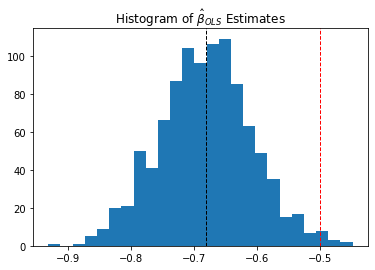

Estimate: -0.6815520904198772


In [4]:
graph_hist(OLS_results, r"Histogram of $\hat{\beta}_{OLS}$ Estimates")

### Estimators with One Instrument

#### IV with One Instrument

This result is particularly hilariously bad.

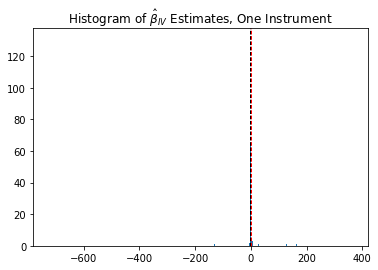

Estimate: -1.5792055610332294
Standard distribution of the IV results: 36.599513235656595


In [10]:
graph_hist(IV_results_one, r"Histogram of $\hat{\beta}_{IV}$ Estimates, One Instrument")
print("Standard distribution of the IV results:", stats.stdev(IV_results_one))

#### HFUL with One Instrument

At these sample sizes, HFUL isn't doing incredibly well, but it is putting positive density at the true value. 

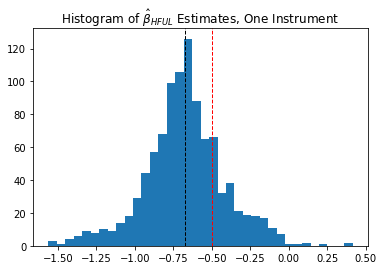

Estimate: -0.6743933659199532


In [6]:
graph_hist(HFUL_results_one, r"Histogram of $\hat{\beta}_{HFUL}$ Estimates, One Instrument")

### Estimators with Multiple Instruments

#### IV with Multiple Instruments

With more instruments, IV has gotten its act together from its embarrassing showing earlier, but the tails are still rather wide.

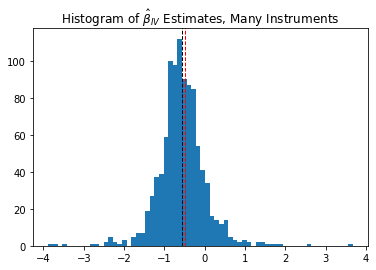

Estimate: -0.5712320142534352


In [7]:
graph_hist(IV_results_many, r"Histogram of $\hat{\beta}_{IV}$ Estimates, Many Instruments")

#### HFUL with Many Instruments

HFUL estimate with multiple instruments is the closest to the true parameter value, and has a fairly narrow distribution around the true value.

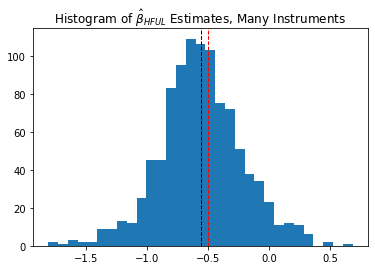

Estimate: -0.5569221675607852


In [8]:
graph_hist(HFUL_results_many, r"Histogram of $\hat{\beta}_{HFUL}$ Estimates, Many Instruments")